# NLP Annotation rendering

There are many types of annotations produced for a given sentence
 - POS tagging
 - NER
 - Universal dependencies
 - Constituency parse tree
 - etc

 Some of these can be illustrated very meaningfully by visually rendering the graphs or annotations. Great for visual understanding and very useful for debugging.

In [4]:
import stanza
import stanza.server.ud_enhancer as ud_enhancer

import nltk

import spacy
from spacy import displacy

import sys
sys.path.append("../../python/")


# Spacy Visualizations

Spacy comes up frequently as a NLP toolkit. There are many example usages of spacy for various NLP tasks and even if StanfordNLP may be better at some things, spacy is considered much faster for many tasks. So keep it in mind and select based on task.

Alongside spaCy's NLP chops, it also has a great visualizer for the various NLP annotations
 - NER/ENT
 - Dependencies
 - Spans


## Displacy external dependencies

Reference: https://spacy.io/usage/visualizers#manual-usage

> From experimentation, the arc items should always have their `start` < `end` with the `dir` specifying the direction of the arrow.

### Display mock external deps

In [5]:


nlp = spacy.load('en_core_web_sm')

# Arcs: By experimentation, it seems that `start < end` always. The dir describes the actual arrow direction.
spacyDeps = {
    "words": [
        {"text": "This", "tag": "DT"},
        {"text": "is", "tag": "VBZ"},
        {"text": "a", "tag": "DT"},
        {"text": "sentence", "tag": "NN"}
    ],
    "arcs": [
        {"start": 0, "end": 1, "label": "nsubj", "dir": "right"},
        {"start": 2, "end": 3, "label": "det", "dir": "left"},
        {"start": 1, "end": 3, "label": "attr", "dir": "right"}
    ]
}

# manual=True must be supplied when we are supplying direct dependency data
displacy.render(spacyDeps, style="dep", manual=True)

## Display Stanford Core NLP Dependencies

The stanford coreNLP dependencies come in multiple forms. The basic parse, `depparseFromStanza` has a field called `depparseFromStanza.dependencies` which is a list of triples and contains what is referred to as the `basic universal dependencies` which can have upto 37 dependencies.

The `enhancedPlusPlusDependencies` have several more and can capture all use cases in many languages. That one needs some extra code that transforms the basic dependencies. The basic deps can also be converted to a spacy format for viz if needed.

In [6]:
from stanza.pipeline.core import DownloadMethod

# Ref: https://github.com/stanfordnlp/stanza/issues/359
# stanza does not like coref or dcoref.
# Looks like I need to directly hit the stanfordCoreNLP server (which is a different thing)
# and use it via that.
enh_ud_nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,lemma,constituency,ner,depparse')
with ud_enhancer.UniversalEnhancer(language="en") as enhancer:
    depparseFromStanza = enh_ud_nlp("John said that he loved mila")
    depparseEnhanced = enhancer.process(depparseFromStanza)

2023-06-14 22:50:39 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-06-14 22:50:40 INFO: Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| constituency | wsj       |
| depparse     | combined  |
| ner          | ontonotes |

2023-06-14 22:50:40 INFO: Using device: cuda
2023-06-14 22:50:40 INFO: Loading: tokenize
2023-06-14 22:50:41 INFO: Loading: pos
2023-06-14 22:50:41 INFO: Loading: lemma
2023-06-14 22:50:41 INFO: Loading: constituency
2023-06-14 22:50:41 INFO: Loading: depparse
2023-06-14 22:50:42 INFO: Loading: ner
2023-06-14 22:50:42 INFO: Done loading processors!


The dependency data (enhanced, enhancedPlusPlus or basic) is of type `CoreNLP_pb2.DependencyGraph`. See [CoreNLP.proto](https://github.com/stanfordnlp/python-corenlp-protobuf/blob/master/doc/CoreNLP.proto) and has the following definition as of June 2023.

```protobuf
//
// A dependency graph representation.
//
message DependencyGraph {
  message Node {
    required uint32 sentenceIndex  = 1;
    required uint32 index          = 2;
    optional uint32 copyAnnotation = 3;
  }

  message Edge {
    required uint32 source     = 1;
    required uint32 target     = 2;
    optional string dep        = 3;
    optional bool   isExtra    = 4;
    optional uint32 sourceCopy = 5;
    optional uint32 targetCopy = 6;
    optional Language language = 7 [default=Unknown];
  }
  
  repeated Node     node     = 1;
  repeated Edge     edge     = 2;
  repeated uint32   root     = 3 [packed=true];
}
```

The code for [corenlp_dtree_visualizer](https://github.com/doug919/corenlp_dtree_visualizer) is 4 years old so not sure how out of date it is. 

It uses the following code to extract the arguments.

```python
# Convert dependency tree formats
sent = ann['sentences'][0]
tree = _corenlp_dep_tree_to_spacy_dep_tree(sent['tokens'], sent['enhancedPlusPlusDependencies'])
```

and the following definition of `_corenlp_dep_tree_to_spacy_dep_tree`

```python
def _corenlp_dep_tree_to_spacy_dep_tree(tokens, dep_tree, attach_root=True):
    '''convert a dependency tree from Stanford Corenlp's JSON output format
        to Spacy's visualizer format
    params:
    '''
    words = [{'text': t['word'], 'tag': t['pos']} for t in tokens]
    if attach_root:
        words = [{'text': '[ROOT]', 'tag': 'ROOT'}] + words

        arcs = []
        for dep in dep_tree:
            if attach_root:
                arc = {'start': dep['governor'], 'end': dep['dependent'], 'label': dep['dep'],
                        'dir': 'left' if dep['governor'] > dep['dependent'] else 'right'}
                arcs.append(arc)
            else:
                if dep['governor'] != 0:
                    arc = {'start': dep['governor']-1, 'end': dep['dependent']-1, 'label': dep['dep'],
                            'dir': 'left' if dep['governor'] > dep['dependent'] else 'right'}
                    arcs.append(arc)
    tree = {'words': words, 'arcs': a
    return tree
```

However, when I examine the current DepTree (protobuf) and python code, there is no `governor`. Going from first principles, I need to populate the data per [displayc manual usage](https://spacy.io/usage/visualizers#manual-usage)

In [7]:
# See "Dep Input" section under https://spacy.io/usage/visualizers#manual-usage
# for data format
words = [ {'text':t.word, 'tag':t.pos} for t in depparseEnhanced.sentence[0].token]

arcs = []
for dep_edge in depparseEnhanced.sentence[0].enhancedPlusPlusDependencies.edge:
    # From experimentation Spacy wants start < end
    # Spacy uses 0 indxed words unlike StanfordCoreNLP's 1 indexed words
    # and the dir to specify the actual direction of the arrow.
    if dep_edge.source < dep_edge.target:    
        arc = {
            'start' : dep_edge.source - 1,
            'end'   : dep_edge.target - 1,
            'label' : dep_edge.dep,
            'dir'   : 'right'
            }    
    else:
        arc = {
            'start' : dep_edge.target - 1,
            'end'   : dep_edge.source - 1,
            'label' : dep_edge.dep,
            'dir'   : 'left'
            }
    
    arcs.append(arc)

tree = {'words' : words, 'arcs' : arcs}
displacy.render(tree, style="dep", manual=True)

In [9]:
# The above code has been  packaged for reuse
from hillops.nlp.viz import get_displaycy_from_stanza_dependencies
tree = get_displaycy_from_stanza_dependencies(
    depparseEnhanced.sentence[0].token,
    depparseEnhanced.sentence[0].enhancedPlusPlusDependencies)

displacy.render(tree, style="dep", manual=True)

# NLTK Tree display

WHen using NLTK functions directly, their tree `nltk.tree.Tree` can be rendered by simply invoking it or using `display(tree)`. Luckily, it is very simple to convert the stanfordNLP _constituency parse tree_ to an nltk tree.

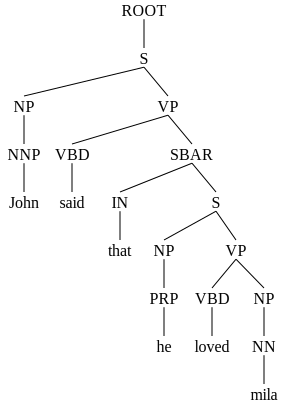

In [18]:
from nltk.tree import Tree
display(Tree.fromstring(str(depparseFromStanza.sentences[0].constituency)))

In [23]:
print(depparseEnhanced.corefChain)

[]


In [29]:

dir(DownloadMethod)

['DOWNLOAD_RESOURCES',
 'NONE',
 'REUSE_RESOURCES',
 '__class__',
 '__doc__',
 '__members__',
 '__module__']

# Using brat

Somewhat surprised that this toolkit did not surface till now. Was looking at the stanford universal dependencies and decided to look at the source. Uses the following
- [annodoc](https://spyysalo.github.io/annodoc/) _(Jekyll → XHTML)_
- [brat](https://brat.nlplab.org/) _(HTML → Visualization)_
  - Server installation
  - Pure JS Embedding _(which is what the [universal dependencies](https://universaldependencies.org/u/dep/conj.html) site uses)_

I was unable to get the snippet below (from https://universaldependencies.org/u/dep/conj.html) to render in the polygot noteboot at [../LLM/TANL/TANL_Polyglot_viz.ipynb](../LLM/TANL/TANL_Polyglot_viz.ipynb), but it works as a standalone HTML file. Some JS issues I am currently unaware of.

The main components are

 - `head.min.js`  _(to parallelly load multiple js down the line)_
 - `anchor.min.js` _(deep anchors. Don't think it has anything to do with the )_


```html
<!DOCTYPE html>
<head>
    <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/font-awesome/4.4.0/css/font-awesome.min.css">
    <link rel="stylesheet" type="text/css" href="https://universaldependencies.org/css/jquery-ui-redmond.css"/>
    <link rel="stylesheet" type="text/css" href="https://universaldependencies.org/css/style.css"/>
    <link rel="stylesheet" type="text/css" href="https://universaldependencies.org/css/style-vis.css"/>
    <link rel="stylesheet" type="text/css" href="https://universaldependencies.org/css/hint.css"/>    
    <script src="https://cdnjs.cloudflare.com/ajax/libs/headjs/0.99/head.min.js"></script>
    <script src="https://cdnjs.cloudflare.com/ajax/libs/anchor-js/3.2.2/anchor.min.js"></script>
    <script>document.addEventListener("DOMContentLoaded", function(event) {anchors.add();console.log("Ran COMContent Loaded");});</script>
</head>
<body>

 <script type="text/javascript">
    console.time('loading libraries');
    var root = 'https://universaldependencies.org/'; // filled in by jekyll
    head.js(
        // External libraries        
        root + 'lib/ext/jquery.min.js',
        root + 'lib/ext/jquery.svg.min.js',
        root + 'lib/ext/jquery.svgdom.min.js',
        root + 'lib/ext/jquery.timeago.js',
        root + 'lib/ext/jquery-ui.min.js',
        root + 'lib/ext/waypoints.min.js',
        root + 'lib/ext/jquery.address.min.js'
    );
</script>


 <h2><code>conj</code>: conjunct</h2>

<p>A conjunct is the relation between two elements connected by a
coordinating conjunction, such as <em>and, or,</em> etc. Coordinate structures 
are in principle symmetrical, but the first conjunction is by convention 
treated as the parent (or “technical head”) of all subsequent coordinated clauses 
via the <code class="language-plaintext highlighter-rouge">conj</code> relation.</p>

<pre><code class="sd-parse">Bill is big and honest
conj(big, honest)
</code></pre>

<div id="punct1" class="language-sdparse">
We have apples , pears , oranges , and bananas .
obj(have, apples)
conj(apples, pears)
conj(apples, oranges)
conj(apples, bananas)
cc(bananas, and)
punct(pears, ,-4)
punct(oranges, ,-6)
punct(bananas, ,-8)
</div>

<p>Coordinated clauses are treated the same way as coordination of other constituent types:</p>

<pre><code class="language-sdparse">He came home , took a shower and immediately went to bed .
conj(came, took)
conj(came, went)
punct(took, ,-4)
cc(went, and)
</code></pre>

<p>Coordination may be <em>asyndetic,</em> which means that the coordinating conjunction is omitted.
Commas or other punctuation symbols will delimit the conjuncts in the typical case.
Asyndetic coordination may be more frequent in some languages, while in others,
conjunction will appear between every two conjuncts <em>(John and Mary and Bill).</em></p>

<pre><code class="language-sdparse">Veni , vidi , vici .
conj(Veni, vidi)
conj(Veni, vici)
punct(vidi, ,-2)
punct(vici, ,-4)
</code></pre>

<script type="text/javascript">
    var root = 'https://universaldependencies.org/'; // filled in by jekyll
    head.js(
        // We assume that external libraries such as jquery.min.js have already been loaded outside!
        // (See _layouts/base.html.)

        // brat helper modules
        root + 'lib/brat/configuration.js',
        root + 'lib/brat/util.js',
        root + 'lib/brat/annotation_log.js',
        root + 'lib/ext/webfont.js',
        // brat modules
        root + 'lib/brat/dispatcher.js',
        root + 'lib/brat/url_monitor.js',
        root + 'lib/brat/visualizer.js',

        // embedding configuration
        root + 'lib/local/config.js',
        // project-specific collection data
        root + 'lib/local/collections.js',

        // Annodoc
        root + 'lib/annodoc/annodoc.js',

        // NOTE: non-local libraries
        'https://spyysalo.github.io/conllu.js/conllu.js'
    );

    var webFontURLs = [
//        root + 'static/fonts/Astloch-Bold.ttf',
        root + 'static/fonts/PT_Sans-Caption-Web-Regular.ttf',
        root + 'static/fonts/Liberation_Sans-Regular.ttf'
    ];

    var setupTimeago = function() {
        jQuery("time.timeago").timeago();
    };

    head.ready(function() {
        setupTimeago();

        // mark current collection (filled in by Jekyll)
        Collections.listing['_current'] = 'u-dep';

	// perform all embedding and support functions
	Annodoc.activate(Config.bratCollData, Collections.listing);
    });
</script>

</body>    
</html>
```